# SARS-COV-2 Ct-Scan Dataset




This notebook caters to the classification of SARS-COV-2 Ct-Scan Dataset which was posted on https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset. It consists of 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. The aim of this dataset is to encourage the research and development of artificial intelligent methods which are able to identify if a person is infected by SARS-CoV-2 through the analysis of his/her CT scans.

**We will highlight a detailed step by step procedure of developing a Deep Learning model which enables us to classify CT scans as belonging to either the covid or non-covid class.**

## Connecting to a GPU

First open Google Coloaboratory. On the Menu Bar, go to Runtime > Change runtime type. Select GPU and click Save.

We then check the GPU information using the `nvidia-smi` command

In [ ]:
!nvidia-smi

Sat Aug 28 05:50:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataset

The dataset used in this notebook was publicly made available by Kaggle. The dataset is available at:
www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset

## Mounting your Google Drive

Run the following command to mount your Google Drive into the Google Colaboratory environment. After running this code cell, a link will appear. Follow that link and grant access to Google Drive. You will get an authentication key which you need to copy and paste into an input box under this cell, and press Enter on yor keyboard.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


## Loading necessary libraries

In [ ]:
# loading packages
import os
import matplotlib.pyplot as plt
import cv2
import shutil
import random
from zipfile import ZipFile
from google.colab import files

## Extracting the Dataset

We can now extract the dataset from our Google Drive into a temporary folder called `dataset` in our Google Colaboratory runtime. Please note that this folder will be automatically removed from memory once your Google Colaboratory session ends or terminates. You will need to remount your drive and run the below code to extract the dataset again in the future.

In [ ]:
# extract dataset images
file_name = '/content/gdrive/MyDrive/archive.zip'
os.makedirs('dataset', exist_ok = True)

with ZipFile(file_name, 'r') as zip_ref:
  zip_ref.extractall('dataset')

print('Extract completed!')

Extract completed!


Next, let us define the paths to the 2 folders, each belonging to its corresponding class:




1.   Covid - '/content/dataset/COVID'
2.   Non- covid - '/content/dataset/non-COVID'


In [ ]:
# path to the data
covid = os.listdir('/content/dataset/COVID')
non_covid = os.listdir('/content/dataset/non-COVID')
print(len(covid),len(non_covid))

1252 1229


## Dataset Visualization

Let us view some samples of each class within our dataset.

### Visualizing some Covid samples from the dataset

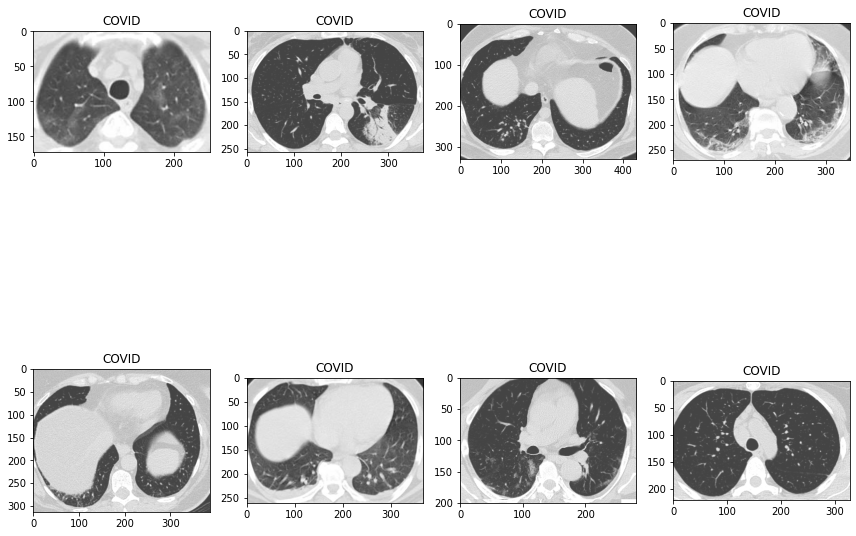

In [ ]:
# Visualizing some Covid samples from the dataset
plt.figure(figsize = (12,12))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    x = random.randint(0, len(covid))
    path = '/content/dataset/COVID/' + covid[x]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('COVID')

plt.tight_layout()
plt.show()

### Visualizing some Non-Covid samples from the dataset

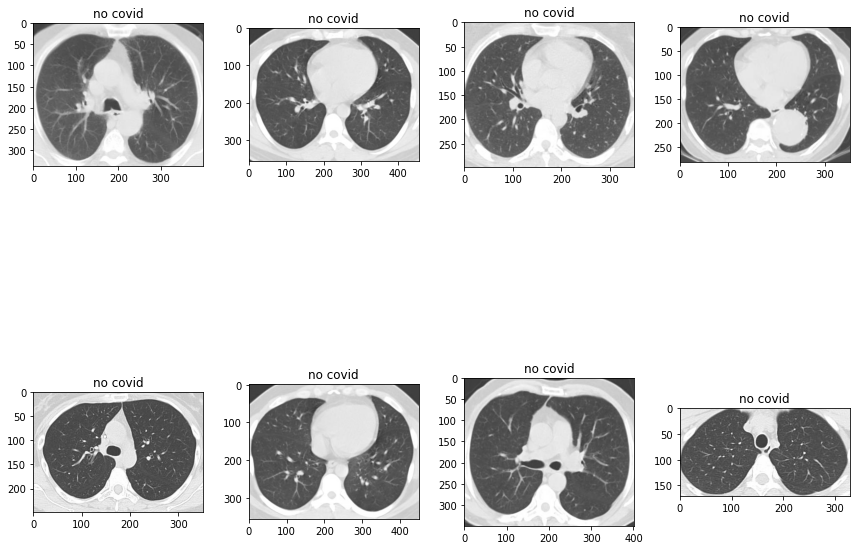

In [ ]:
# Visualizing some Non-covid samples from the dataset
plt.figure(figsize = (12,12))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    x = random.randint(0, len(non_covid))
    path = '/content/dataset/non-COVID/' + non_covid[x]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('no covid')
plt.tight_layout()
plt.show()

## Splitting the dataset into train and validation sets 

We use the [split-folders](https://pypi.org/project/split-folders/) library to split the dataset into train, validation and test sets. For this, we need to specify the path to the original dataset (the `/content/dataset` folder) and the path to the folder with the split dataset (the `dataset_split` folder).

We then call the split-folders library using the 2 paths defined above, along with a seed (to give the exact same folder splits every time you split the dataset) and a ratio for the splitting the dataset (ratio format: train, val, test(Optional)). For the given task, we used a split ratio of 80:20 for the train:val sets. Note: I have already taken out the test dataset separately, hence not creating one here

In [ ]:
# splitting dataset into train, validation and test sets
!pip install split-folders

import splitfolders

orig_path = '/content/dataset/'
output_path = '/content/dataset_split/'
splitfolders.ratio(orig_path, output = output_path, seed = 1254, ratio = (.80, .20))

Copying files: 2481 files [00:00, 5106.33 files/s]


Let us check the number of images in each of the sets we created.

In [ ]:
# counting number of images
total_train = 0
for root, dirs, files in os.walk('/content/dataset_split/train'):
    total_train += len(files)
print('Train set size: ', total_train)

total_val = 0
for root, dirs, files in os.walk('/content/dataset_split/val'):
    total_val += len(files)
print('Validation set size: ', total_val)

Train set size:  1984
Validation set size:  497


## Setting up the Model Training

Let us begin by importing the required libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

In [ ]:
train_data_path = '/content/dataset_split/train'
validation_data_path = '/content/dataset_split/val'

Now, we define some training hyperparameters:

*   img_width: Width of input image in pixels
*   img_height: Height of input image in pixels
*   channels: Numbers of color channels in image
*   batch_size: The number of training samples to work through before the model’s internal parameters are updated 
*   validation_steps: validation_set_size / batch_size
*   classes_num: Number of classes, 3 in our case
*   lr: Learning Rate. The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. It  controls how quickly the model is adapted to the problem
*   epochs: The number of epochs controls the number of complete passes through the training dataset


In [ ]:
img_width =  512
img_height = 512
channels = 3
batch_size = 16
validation_steps = 31
classes_num = 2
lr = 0.001
epochs = 50

We then define our training and validation generators using the defined hyperparameters. More information on this available [here](https://keras.io/api/preprocessing/image/).

ImageDataGenerator: Generate batches of tensor image data with real-time data augmentation. Read more [here](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/).

train_generator: Takes the path to a directory & generates batches of augmented data for training, based on the train image data generator.

validation_generator: Takes the path to a directory & generates batches of augmented data for validation, based on the validation image data generator.




## **Data Augmentation using imgaug library**

Now Image data generator does allow us to perform image augmentation on our data set (on the fly), but it only allows for specific ones which do not really cater to the needs our dataset. Hence to leverage the true power of data augmentation, we make use of the imgaug library, which conveniently allows us to perform advanced augmentation in just a few lines of code.


Note: In order to use all the augmentations used in this notebook, we will have to install imgaug version "0.4.0"

In [ ]:
!pip install imgaug==0.4.0

     |████████████████████████████████| 948 kB 15.5 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [ ]:
import imgaug.augmenters as iaa
import imgaug as ia
import numpy
import glob

In [ ]:
print(ia.__version__)

0.4.0


This is our augmentation function that takes in an input image and performs one of the four listed augmentation techniques and returns it.

In [ ]:
def img_augmentator(image):
  #image = tensor_image.numpy()
  aug = iaa.Sequential([iaa.Sometimes(0.5, [iaa.OneOf([iaa.GaussianBlur((0, 2.0)), 
                   iaa.MedianBlur(k=(3, 11)), 
                   iaa.AverageBlur(k=(2, 5))])]),
                     
                     iaa.Sometimes(0.6, [iaa.OneOf([ia.augmenters.color.MultiplyBrightness((0.7,1.2)),
                              iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))])]),
                     
                     iaa.Sometimes(0.5, [iaa.Crop(percent=(0, 0.1)),
                                        iaa.Affine(translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)},
                                        shear=(-10, 10))])])
  
  aug_img = aug(image=image)
  return aug_img

Here, we have defined a convenience function that allows to perform image augmention by caling the fucntion defined above 'n' times and hence, we can decide how many augmentations per image we desire.

In [ ]:
def augment_images(folder):
  images = glob.glob(folder+'/*.png')
  for image in images:
    name = image.split('/')[-1].split('.')[0]
    bgr_img = cv2.imread(image, cv2.IMREAD_COLOR)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    i=0
    while True:
      i+=1
      aug_img = img_augmentator(rgb_img)
      cv2.imwrite(folder+'/'+name+f'_aug_{i}.png', aug_img[:,:,::-1])
      if i==5:
        break

In [ ]:
augment_images('/content/dataset_split/train/COVID')

In [ ]:
augment_images('/content/dataset_split/train/non-COVID')

This is an example for how the img_augmentator function takes in an input image and returns its augmented versions.

In [ ]:
bgr_img = cv2.imread('/content/dataset_split/train/non-COVID/Non-Covid (100).png', cv2.IMREAD_COLOR)
rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

aug_list=[]
aug_list.append(rgb_img)
for i in range(5):
  aug_img = img_augmentator(rgb_img)

  aug_list.append(aug_img)

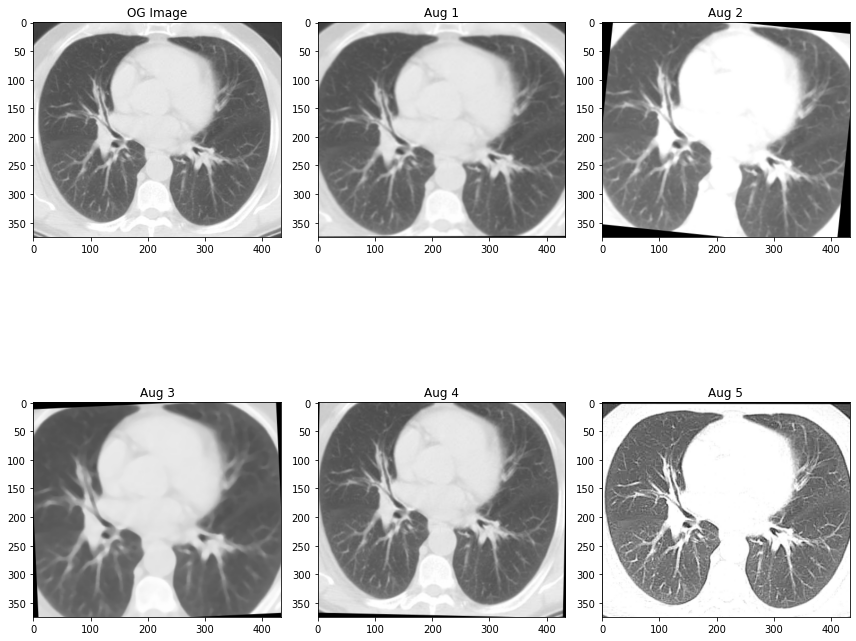

In [ ]:
plt.figure(figsize=(12,12))

title=['OG Image', 'Aug 1', 'Aug 2', 'Aug 3', 'Aug 4', 'Aug 5']
for i in range(len(aug_list)):
  plt.subplot(2,3, i+1)
  plt.imshow(aug_list[i])
  plt.title(title[i])

plt.tight_layout()
plt.show()

Let us use the Image data generator now generate batches of tensor image data

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_path,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary')

Found 11904 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


We now define our Dense Net 121 model. The input shape uses the same image height, image width and number of channels that we defined earlier. We use `imagenet` weights as the starting weights and exclude the top layer, in order to train the model for our custom number of classes.

In [ ]:
base_model = tf.keras.applications.DenseNet121(input_shape=(512,512,3), weights='imagenet', include_top=False)

29097984/29084464 [==============================] - 0s 0us/step


Let us take a look at our base model, without the final few layers.

In [ ]:
#base_model.summary()

Then, we add a few more layers to the base model and use a softmax layer with 3 outputs as the final layer, for the 3 classes in our task.

Let us then take a look at our final model architecture summary!



In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1,activation='sigmoid')(x)
model = Model(inputs = base_model.input, outputs = x)

#model.summary()

## Optimizer and Callbacks

Now that we have our model architecture ready, we need to define the other aspects of training like an optimizer and the callbacks.

An [optimizer](https://keras.io/api/optimizers/) is a method or algorithm to update the various parameters that can reduce the loss in much less effort. One of the most commonly used and best optimizers is [Adam](https://keras.io/api/optimizers/adam/).

In [ ]:
adam = optimizers.Adam(learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8)
model.compile(loss = 'binary_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'])

Next, we create a directory to save our model weights. We create a `snapshots` folder in the Google Colaboratory environment for this purpose. However, please note that like the extracted dataset, these weights will be deleted once your session terminates.

Thus, if you have ample space in your Google Drive, you can temporarily save your model weights there. After the training is complete, you can sleect the best weights and the discard the others. For our task, we created a `snapshots` folder inside our google drive directly. 

In case you do not have enough space in Google Drive, you can proceed with storing your model weights in the Google Coloboratory environment and then copy the best weights to your Google Drive, after the training process.

In [ ]:
target_dir = './snapshots'

if not os.path.exists(target_dir):
  os.mkdir(target_dir)

Here, we define our model callbacks. A [callback](https://keras.io/api/callbacks/) is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

*   [checkpoints](https://keras.io/api/callbacks/model_checkpoint/): A callback to save the Keras model or model weights at some frequency It is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved. We will be saving the best weights only, based on validation loss.

*   [lr_op](https://keras.io/api/callbacks/reduce_lr_on_plateau/): Reduce learning rate on plateau, a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. We will be monitoring the validation loss stagnation over a period of 5 epochs (patience = 5) and reduce the learning rate by a factor of 0.1 (factor = 0.1) upon a learning plateau.


In [ ]:
file_path = 'snapshots/best_weight{epoch:03d}.h5'
checkpoints = callbacks.ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 0, save_best_only = True, mode = 'auto')
lr_op = callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 5,
  verbose = 1, mode = "auto", cooldown = 0,
  min_lr = 1e-30)

cbks = [ checkpoints, lr_op]

## Model Training

Finally, we can begin with our model trainig. We call the fit() method for this purpose. We pass the train and validation generators, number of epochs, callbacks, steps_per_epochs (train_set_size / batch_size), validation_steps(validation_set_size / batch_size).

In [29]:
history = model.fit(train_generator, epochs=50, verbose=1, callbacks=cbks, validation_data=validation_generator, steps_per_epoch=744, validation_steps=validation_steps)

Epoch 1/50
744/744 [==============================] - 353s 438ms/step - loss: 0.5729 - accuracy: 0.7248 - val_loss: 0.5242 - val_accuracy: 0.6915
Epoch 2/50
744/744 [==============================] - 324s 436ms/step - loss: 0.4008 - accuracy: 0.8338 - val_loss: 1.3106 - val_accuracy: 0.5040
Epoch 3/50
744/744 [==============================] - 324s 435ms/step - loss: 0.3393 - accuracy: 0.8638 - val_loss: 0.2332 - val_accuracy: 0.9315
Epoch 4/50
744/744 [==============================] - 324s 435ms/step - loss: 0.3198 - accuracy: 0.8720 - val_loss: 0.7821 - val_accuracy: 0.7520
Epoch 5/50
744/744 [==============================] - 324s 435ms/step - loss: 0.3019 - accuracy: 0.8803 - val_loss: 1.3454 - val_accuracy: 0.5444
Epoch 6/50
744/744 [==============================] - 324s 435ms/step - loss: 0.2859 - accuracy: 0.8857 - val_loss: 0.2400 - val_accuracy: 0.9234
Epoch 7/50
744/744 [==============================] - 324s 435ms/step - loss: 0.2757 - accuracy: 0.8910 - val_loss: 0.4999 -

Copy the best weights from the snapshot directory onto your google drive

In [30]:
!cp -r /content/snapshots/best_weight044.h5 /content/gdrive/MyDrive

# **Best Model Weights Stats**
**Loss**: 0.0053

**Accuracy**: 0.9984

**Val Loss**: 0.0414

**Val Accuracy**: 0.9879

## Plotting Graphs

Let us visualize the graphs for train loss, train accuracy, validation loss, validation accuracy.

The loss graphs should ideally show a gradual decrease, while the accuracy graphs should ideally show a gradual increase.

### Train Loss

We can see the train loss starting at a very high value initially. As the number of epochs increase, the model learns and the train loss decreases after some initial instabilty. We can see that the train loss is around 0.03-0.04 towards the final few epochs.

Text(0.5, 1.0, 'Train loss')

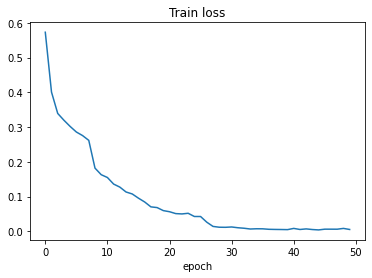

In [31]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.title('Train loss')

### Train Accuracy
We can see the train accuracy starting at a very low value initially. As the number of epochs increase, the model learns and the train accuracy increases after some initial instabilty. We can see that the train accuracy is around 98-99% towards the final few epochs.

Text(0.5, 1.0, 'Train Accuracy')

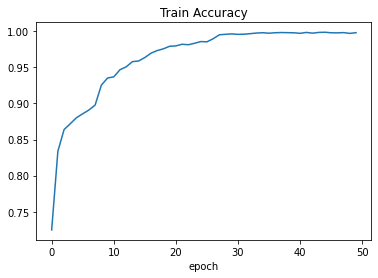

In [32]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.title('Train Accuracy')

### Validation Loss

We can see the validation loss being very unstable and exploding to a very high value initially. As the number of epochs increase, the model learns and the validation loss decreases after some initial instabilty. We can see that the train loss is around 0.04-0.05 towards the final few epochs.

Text(0.5, 1.0, 'Validation loss')

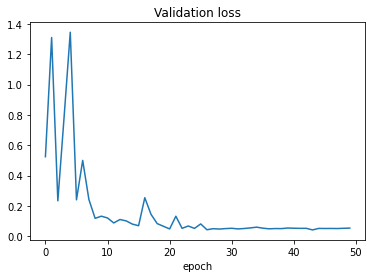

In [33]:
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.title('Validation loss')

### Validation Accuracy

We can see the validation accuracy starting at a very low value initially and acting very unstable. As the number of epochs increase, the model learns and the validation accuracy increases after some initial instabilty. We can see that the validation accuracy is around 98-99% towards the final few epochs.

Text(0.5, 1.0, 'Validation Accuracy')

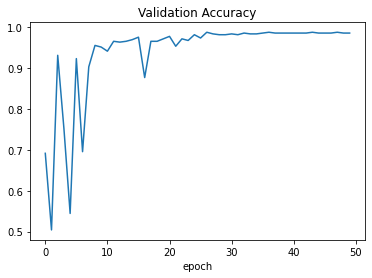

In [34]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.title('Validation Accuracy')

### Combining train and validation graphs

Let us visualize the train and validation graphs together for comparison. The blue line represents the train metric and the orange line represents the validation metric. 

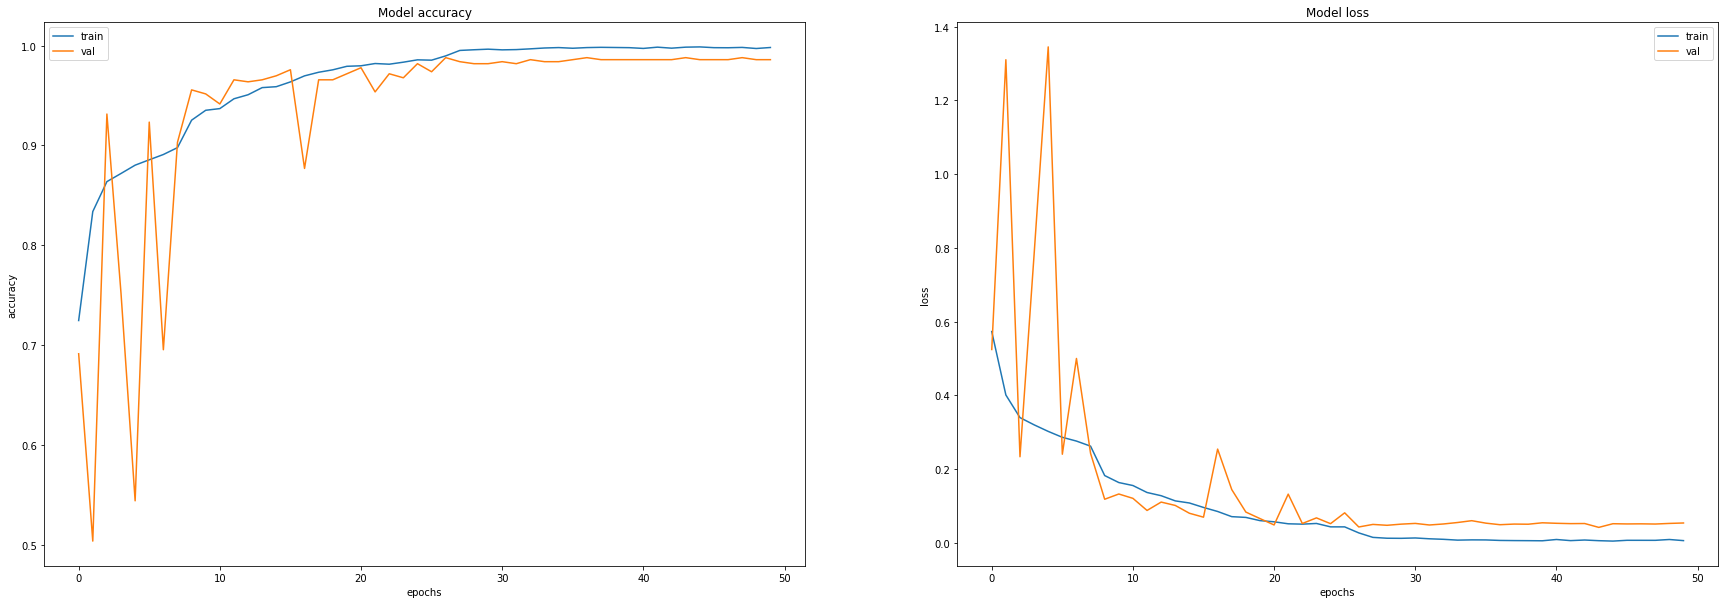

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric][:])
    ax[i].plot(model.history.history["val_" + metric][:])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])